### Imports libraries & display settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

### Load the assembled dataset

In [2]:
DATA_PATH = "../../data/processed_data/riders_trips_rfms.csv"

df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
display(df.head(5))

Dataset shape: (10000, 16)


,user_id,recency,total_trips,total_spend,avg_spend,avg_surge,total_tip,avg_tip,avg_rating_given,loyalty_status,city,avg_distance,avg_duration,active_days,RFMS_weighted_score,RFMS_segment
0,R00000,26,25,366.05,14.642000,1.096000,4.03,0.161200,5.0,Bronze,Nairobi,3.945572,30.320000,336,2.80,Core Loyal Riders
1,R00001,6,14,180.53,12.895000,1.071429,0.76,0.054286,4.7,Bronze,Nairobi,4.056645,28.642857,346,1.90,At Risk
2,R00002,15,24,378.99,15.791250,1.191667,5.21,0.217083,4.2,Bronze,Lagos,4.533116,31.541667,298,3.40,High-Value Surge-Tolerant
3,R00003,62,9,121.47,13.496667,1.155556,0.87,0.096667,4.9,Bronze,Nairobi,4.837392,32.555556,285,1.40,At Risk
4,R00004,13,16,268.43,16.776875,1.262500,9.38,0.586250,3.9,Silver,Lagos,4.677326,36.125000,326,2.45,Occasional Riders


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              10000 non-null  object 
 1   recency              10000 non-null  int64  
 2   total_trips          10000 non-null  int64  
 3   total_spend          10000 non-null  float64
 4   avg_spend            10000 non-null  float64
 5   avg_surge            10000 non-null  float64
 6   total_tip            10000 non-null  float64
 7   avg_tip              10000 non-null  float64
 8   avg_rating_given     10000 non-null  float64
 9   loyalty_status       10000 non-null  object 
 10  city                 10000 non-null  object 
 11  avg_distance         10000 non-null  float64
 12  avg_duration         10000 non-null  float64
 13  active_days          10000 non-null  int64  
 14  RFMS_weighted_score  10000 non-null  float64
 15  RFMS_segment         10000 non-null  

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
recency,10000.0,19.169900,18.363659,1.000000,6.000000,13.000000,26.000000,175.000000
total_trips,10000.0,20.000000,4.498380,6.000000,17.000000,20.000000,23.000000,42.000000
total_spend,10000.0,308.025691,74.760409,78.870000,255.260000,304.725000,356.750000,663.910000
avg_spend,10000.0,15.398338,1.405701,11.030833,14.410978,15.304750,16.282675,22.142222
avg_surge,10000.0,1.141572,0.058819,1.000000,1.100000,1.136364,1.177778,1.412500
total_tip,10000.0,9.391318,6.108403,0.000000,4.900000,8.190000,12.590000,46.290000
avg_tip,10000.0,0.469579,0.292674,0.000000,0.255714,0.412083,0.621446,2.708462
avg_rating_given,10000.0,4.461510,0.429162,2.600000,4.200000,4.500000,4.800000,5.000000
avg_distance,10000.0,4.148744,0.382194,2.632150,3.893931,4.144563,4.407904,5.652125
avg_duration,10000.0,31.952998,3.624179,16.583333,29.545455,32.000000,34.333333,46.833333


### Define Churn Logic

In [5]:
# Create the churn label
CHURN_THRESHOLD_DAYS = 30

# Define Churn Logic
df["churned"] = (df["recency"] > CHURN_THRESHOLD_DAYS).astype(int)

df["churned"].value_counts(normalize=True)

churned
0    0.8007
1    0.1993
Name: proportion, dtype: float64

### Validate the Churn Labels

In [6]:
print("Churned users:", df["churned"].sum())
print("Active users:", (df["churned"] == 0).sum())

df.groupby("churned")["recency"].describe()

Churned users: 1993
Active users: 8007


,count,mean,std,min,25%,50%,75%,max
churned,,,,,,,,
0,8007.0,11.813039,8.055121,1.0,5.0,10.0,18.0,30.0
1,1993.0,48.726543,18.448778,31.0,36.0,43.0,56.0,175.0


## Churn-Aware EDA

In [7]:
df.groupby("churned")[["total_trips", "total_spend"]].mean()

,total_trips,total_spend
churned,,
0,20.365180,313.531067
1,18.532865,285.907506


### Visualize recency distribution

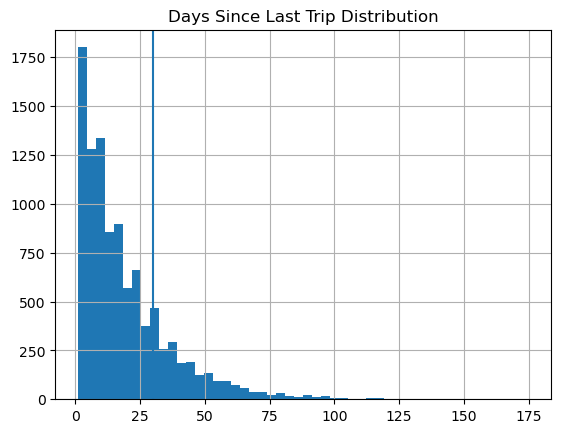

In [8]:
plt.figure()
df["recency"].hist(bins=50)
plt.axvline(CHURN_THRESHOLD_DAYS)
plt.title("Days Since Last Trip Distribution")
plt.show()

### Churn rate Understanding

In [9]:
df["churned"].value_counts(normalize=True) * 100

churned
0    80.07
1    19.93
Name: proportion, dtype: float64

### Boxplots by churn status

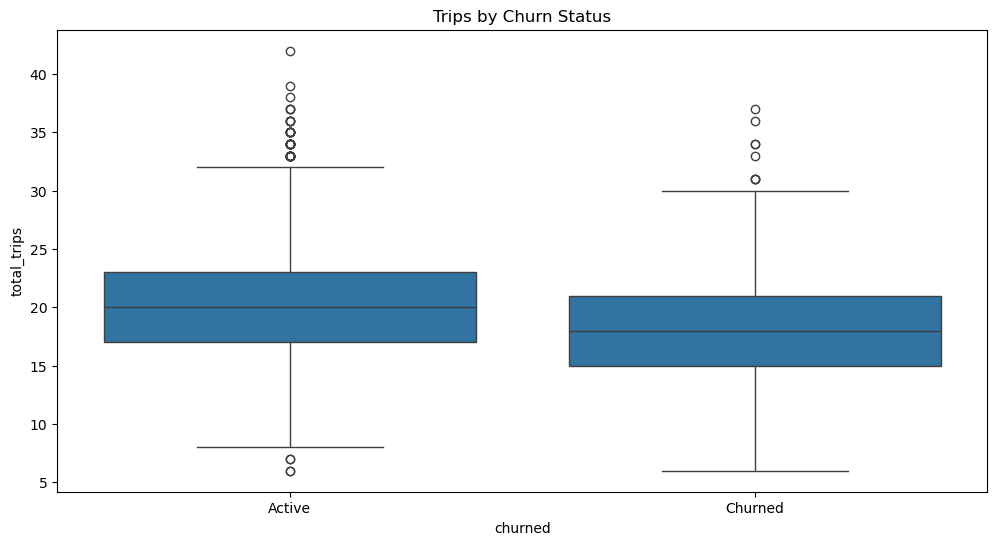

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="churned",
    y="total_trips",
    data=df
)
plt.title("Trips by Churn Status")
plt.xticks([0, 1], ["Active", "Churned"])
plt.show()

### Churn by city

In [11]:
df.columns

Index(['user_id', 'recency', 'total_trips', 'total_spend', 'avg_spend', 'avg_surge', 'total_tip', 'avg_tip',
       'avg_rating_given', 'loyalty_status', 'city', 'avg_distance', 'avg_duration', 'active_days',
       'RFMS_weighted_score', 'RFMS_segment', 'churned'],
      dtype='object')

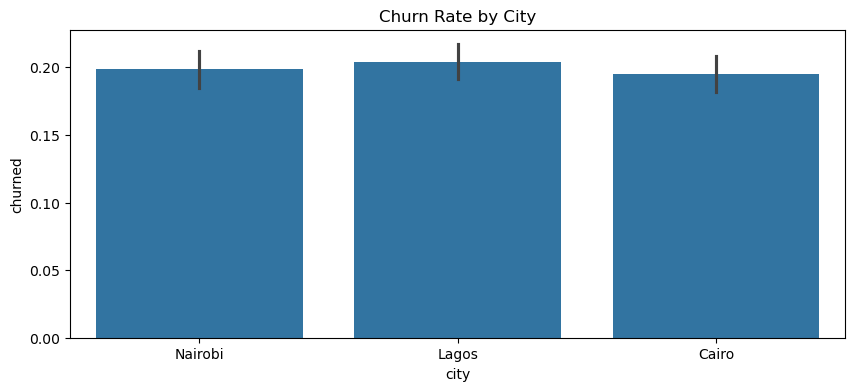

In [12]:
plt.figure(figsize=(10, 4))
sns.barplot(
    x="city",
    y="churned",
    data=df
)
plt.title("Churn Rate by City")
plt.show()

### Churn by loyalty status

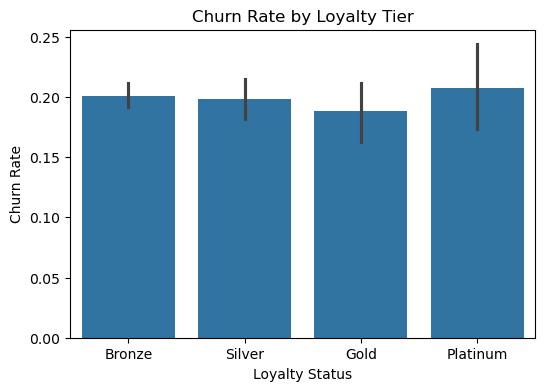

In [13]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=df,
    x="loyalty_status",
    y="churned",
    estimator=lambda x: x.mean()
)
plt.title("Churn Rate by Loyalty Tier")
plt.ylabel("Churn Rate")
plt.xlabel("Loyalty Status")
plt.show()

### Recency distribution

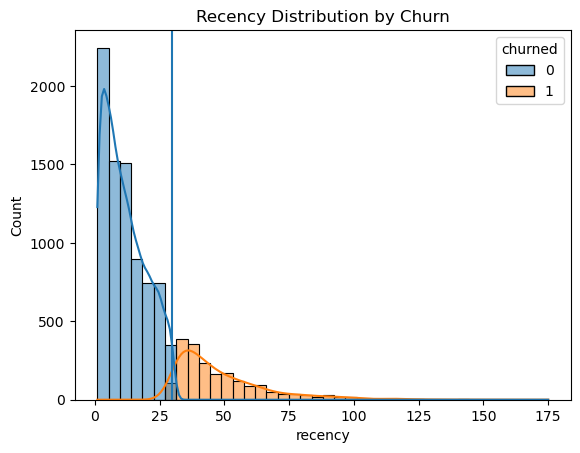

In [14]:
plt.figure()
sns.histplot(
    data=df,
    x="recency",
    hue="churned",
    bins=40,
    kde=True
)
plt.axvline(30)
plt.title("Recency Distribution by Churn")
plt.show()

### Age distribution by churn

In [15]:
# plt.figure(figsize=(6,4))
# sns.boxplot(
#     data=df,
#     x="churned",
#     y="age"
# )
# plt.xticks([0,1], ["Active", "Churned"])
# plt.title("Age Distribution by Churn Status")
# plt.show()

### Correlation heatmap (numeric features)

In [16]:
df.columns

Index(['user_id', 'recency', 'total_trips', 'total_spend', 'avg_spend', 'avg_surge', 'total_tip', 'avg_tip',
       'avg_rating_given', 'loyalty_status', 'city', 'avg_distance', 'avg_duration', 'active_days',
       'RFMS_weighted_score', 'RFMS_segment', 'churned'],
      dtype='object')

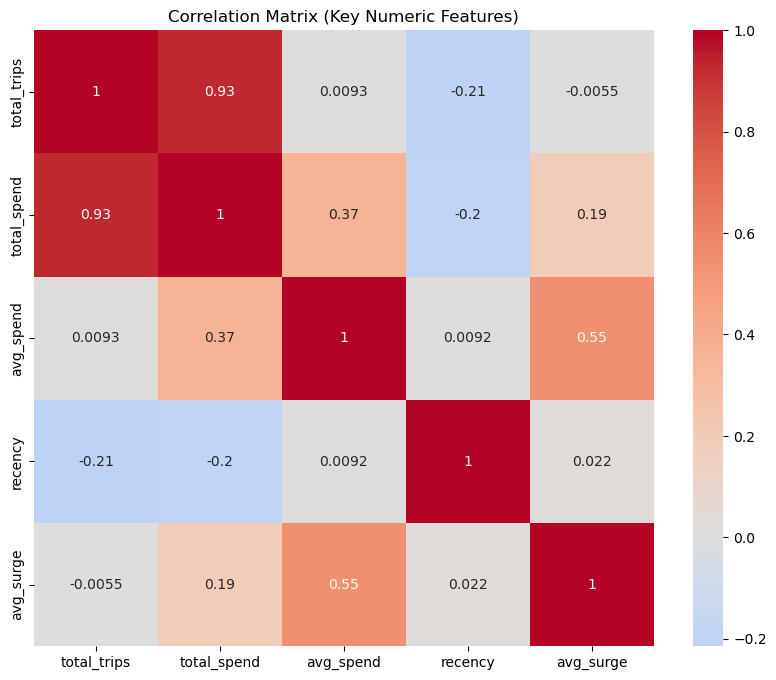

In [20]:
numeric_cols = [
    'total_trips', 'total_spend', 'avg_spend', 'recency', 'avg_surge'
]

plt.figure(figsize=(10,8))
sns.heatmap(
    df[numeric_cols].corr(),
    cmap="coolwarm",
    center=0,
    annot=True
)
plt.title("Correlation Matrix (Key Numeric Features)")
plt.show()

### Pairplot

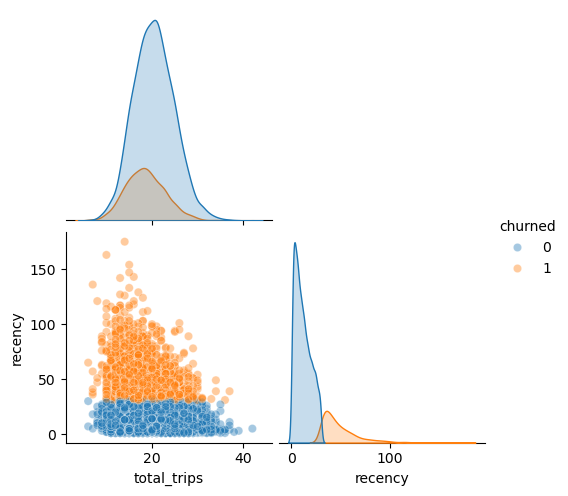

In [18]:
sns.pairplot(
    df,
    vars=[
        "total_trips",
        "recency"
    ],
    hue="churned",
    corner=True,
    plot_kws={"alpha": 0.4}
)
plt.show()

### Save the FINAL Output

In [21]:
os.makedirs('../../data/processed_data/', exist_ok=True)
FINAL_OUTPUT_PATH = "../../data/processed_data/riders_trips_rfms_churned.csv"

df.to_csv(FINAL_OUTPUT_PATH, index=False)

print(f"Final churn dataset saved to: {FINAL_OUTPUT_PATH}")

Final churn dataset saved to: ../../data/processed_data/riders_trips_rfms_churned.csv
